# Run linescans to test GP parameters for H1, deltaH, S6, S7, S3, S4, Obj
GPT linescans can be used to roughly check the performance of CNN, see whether it has unwanted local minima.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pickle
import numpy as np
from modules.bayes_optimization import BayesOpt, negUCB, negExpImprove
from modules.OnlineGP import OGP
import numpy as np
import importlib
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
import sys
import os
sys.path.insert(1, '/home/chenyu/Desktop/Bayesian-optimization-using-Gaussian-Process/GPTrelated')
saveResultsQ = False
import scipy
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
os.environ["CUDA_VISIBLE_DEVICES"]="0" # specify which GPU to use
if gpus:
  try:
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)

In [3]:
# free space from GPU device
from numba import cuda
cuda.select_device(0)
cuda.close()

## Use existing ronchigram arrays to test each model

In [5]:
from keras import applications, optimizers, callbacks
from keras.models import Sequential, load_model
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [6]:
def aperture_generator(px_size, simdim, ap_size):
    x = np.linspace(-simdim, simdim, px_size)
    y = np.linspace(-simdim, simdim, px_size)
    xv, yv = np.meshgrid(x, y)
    apt_mask = mask = np.sqrt(xv*xv + yv*yv) < ap_size # aperture mask
    return apt_mask

In [7]:
# model_path = 'CNNmodels/VGG16_coarse_linear_highCs_3fold_C5_negC1_WhiteNoise_newData_noFeatureCenter.h5'
# model_path = 'CNNmodels/VGG16_coarse_linear_highCs_3fold_C5_negC1_WhiteNoise_newData_smallShift.h5'
# model_path = 'CNNmodels/VGG16_coarse_linear_highCs_3fold_C5_negC1_WhiteNoise_newData.h5'
# model_path = 'CNNmodels/VGG16_coarse_linear_highCs_3fold_C5_negC1_WhiteNoise.h5'
# model_path = 'CNNmodels/VGG16_coarse_linear_highCs_3fold_C5_WhiteNoise.h5'
# model_path = 'CNNmodels/VGG16_test13_attempt06.h5'
# model_path = 'CNNmodels/VGG16_smallDefocus.h5'
# model_path = 'CNNmodels/VGG16_emit+defocus_test6_attempt3.h5'
# model_path = 'CNNmodels/VGG16_emit+defocus_40mradApt_test12_03.h5'
# model_path = 'CNNmodels/VGG16_emit+defocus_30mradApt_test12_01.h5'
model_path = 'CNNmodels/VGG16_25mrademit+defocus_25mradApt_test12_02.h5'
model_path = 'CNNmodels/VGG16_30mrademit+defocus_30mradApt_lowAbr_test12_05.h5'

In [8]:
model = applications.VGG16(weights=None, include_top=False, input_shape=(128, 128, 3))
top_model = Sequential()
top_model.add(Flatten(input_shape=model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dense(1,activation=None))
new_model = Sequential()

for l in model.layers:
    new_model.add(l)

new_model.add(top_model)
new_model.load_weights(model_path)

In [9]:
def scale_range(input, min, max):
    input += -(np.min(input))
    input /= np.max(input) / (max - min)
    input += min
    return input

In [36]:
# ronch_list = np.load('Results/Linescans/VGG16_test13_attempt06/H1_1000_2800_100steps_RonchigramList.npy')
# ronch_list = np.load('Results/Linescans/VGG16_test13_attempt06/deltaH_-40_40_100steps_RonchigramList.npy')
# ronch_list = np.load('Results/Linescans/VGG16_test13_attempt06/OBJ_-3.7515e6_-3.7495e6_100steps_Ronchigram_list.npy')
# ronch_list = np.load('Results/Linescans/VGG16_test13_attempt06/S3_1.19e5_1.203e5_100steps_Ronchigram_list.npy')
# ronch_list = np.load('Results/Linescans/VGG16_test13_attempt06/S4_6.4e5_6.51e5_100steps_Ronchigram_list.npy')
# ronch_list = np.load('Results/Linescans/VGG16_test13_attempt06/S6_3.87e5_3.93e5_100steps_Ronchigram_list.npy')
ronch_list = np.load('Results/Linescans/VGG16_test13_attempt06/S7_-6.85e5_-6.225e5_100steps_Ronchigram_list.npy')

x_list = []
for i in range(ronch_list.shape[0]):
    # apply the same process to loaded frame as machine_interface_GPT.py
    frame = ronch_list[i,:,:] * aperture_generator(128, 40, 30)
#     frame = ronch_list[i,:,:]
    frame = scale_range(frame, 0, 1)
    new_channel = np.zeros(frame.shape)
    img_stack = np.dstack((frame, new_channel, new_channel))
    x_list.append(img_stack)
x_list = np.concatenate([arr[np.newaxis] for arr in x_list])
prediction = 1 - new_model.predict(x_list, batch_size = 1)

# np.save('H1_1000_2800_100steps_40mrad_Coarse_CNNemittance.npy',prediction)
# np.save('deltaH_-40_40_100steps_40mrad_Coarse_CNNemittance.npy',prediction)
# np.save('OBJ_-3.7515e6_-3.7495e6_100steps_40mrad_Coarse_CNNemittance.npy',prediction)
# np.save('S3_1.19e5_1.203e5_100steps_40mrad_Coarse_CNNemittance.npy',prediction)
# np.save('S4_6.4e5_6.51e5_100steps_40mrad_Coarse_CNNemittance.npy',prediction)
# np.save('S6_3.87e5_3.93e5_100steps_40mrad_Coarse_CNNemittance.npy',prediction)
np.save('S7_-6.85e5_-6.225e5_100steps_40mrad_Coarse_CNNemittance.npy',prediction)

47


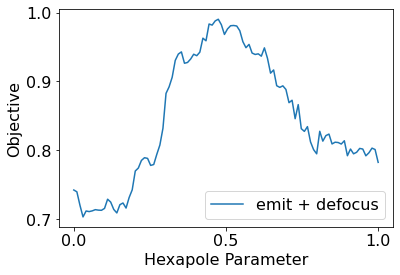

In [37]:
# H1_list = np.linspace(1000,2200,num=100)
# deltaH_list = np.linspace(-20,20,num=100)
# OBJ_list = np.linspace(-3.7515e6,-3.7495e6,num=100)
# S3_list = np.linspace(1.19e5, 1.203e5, num=100)
# S4_list = np.linspace(6.4e5, 6.51e5, num=100)
# S6_list = np.linspace(3.87e5, 3.91e5, num=100)
# S7_list = np.linspace(-6.55e5,-6.35e5, num=100)
x_list = np.linspace(0,1,num=100)
plt.plot(x_list, prediction[:,0], label = 'emit + defocus')
print(np.argmax(prediction[:,0]))
# plt.plot(x_list, emit_profile)

plt.ylabel('Objective', fontsize = 16)
plt.xlabel('Hexapole Parameter', fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.locator_params(axis="x", nbins=4)
plt.locator_params(axis="y", nbins=6)
plt.legend(fontsize=16)

## Run line scan for each of the parameter

Model loaded
Model loaded
Using CNN prediction.
saving ronchigram...
(array([[0.27678667, 0.27678667, 0.5       , 0.4944    , 0.71653846,
        0.79012864]]), array([[0.93075947]]))


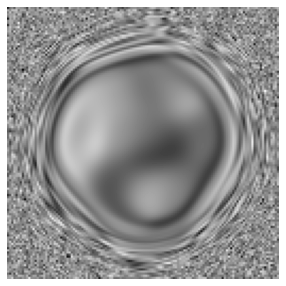

In [12]:
ndim = 6
model_path = 'CNNmodels/VGG16_emit+defocus_test6_attempt3.h5'
dev_ids =  [str(x+1) for x in np.arange(ndim)]
x_low = np.asarray([1000, -40, 387000, -685000, 119000, 640000])
x_high = np.asarray([2800, 40, 393000, -622500, 120300, 651000])
start_point = [1498.216 , 0.47, 390000 , -654100, 119931.5, 648691.415]
start_point = [(start_point - x_low)/(x_high - x_low)]
mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point, CNNoption=1,
                                CNNpath = model_path, DefocusOption = 1, S2 = 1)
mi.aperture = 40
print(mi.getState())
fig = plt.figure(figsize = [5,5])
temp = np.load('ronchigram.npy')
plt.imshow(temp, cmap='gray')
plt.axis('off')
plt.show()

1.0 [0.7637841]


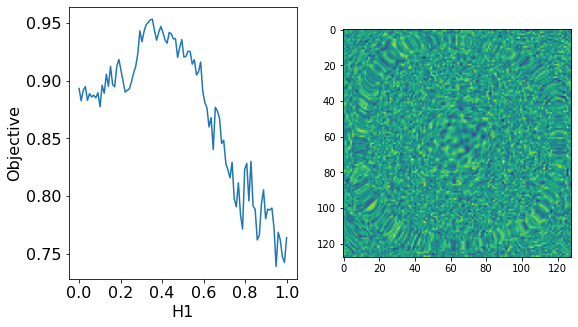

In [24]:
# Line scan for H1
# Include defocus correction to each step of linescan
# Parameters in the order of H1, dH, S6, S7, S3, S4
# Objective lens and S1, S2 condenser lenses are fixed here.

H1_list = np.linspace(0, 1,num=100)
emit_profile = np.zeros([100,1])
defocus_list = np.zeros([100,1])
ronch_list = []
# emit_profile = np.load('H1_1000_2800_100steps_40mrad_Coarse_CNNemittance.npy')

for i in range(len(H1_list)):
    
    if emit_profile[i] == 0:
    
        start_point = [[H1_list[i], 0.505875, 0.5, 0.4944, 0.71653846, 0.79012864]]    
        mi.aperture = 40
        mi.setX(start_point)
        mi.setS2(1)

        temp = mi.getState()
        emit_profile[i] = temp[1][0]
        # defocus correction option
#         defocus = mi.getDefocus()
#         if defocus < 0.85:
#             print('Correct defocus...')
#             new_S2 = mi.CorrectDefocus(mi.x, mi.S2)
#             mi.setS2(new_S2[0][0])
#             emit_profile[i] = mi.getState()[1][0]
#         else:
#             emit_profile[i] = temp[1][0]
#         defocus_list[i] = defocus

        clear_output(wait=True)
        print(H1_list[i], emit_profile[i])
        fig = plt.figure(figsize = [9,5])
        plt.subplot(121)
        plt.plot(H1_list, emit_profile)
        plt.xlabel('H1', fontsize=16)
        plt.ylabel('Objective', fontsize = 16)
        plt.xticks(fontsize=16)
        plt.yticks(fontsize=16)
        plt.locator_params(axis="x", nbins=6)
        plt.locator_params(axis="y", nbins=6)

        temp = np.load('ronchigram.npy')
        ronch_list.append(temp)

        plt.subplot(122)
        plt.imshow(temp)
        plt.show()

        np.save('H1_1000_2800_100steps_40mrad_Coarse_CNNemittance.npy',emit_profile)
        np.save('H1_1000_2800_100steps_RonchigramList.npy', np.asarray(ronch_list))

1.0 [0.84023027]


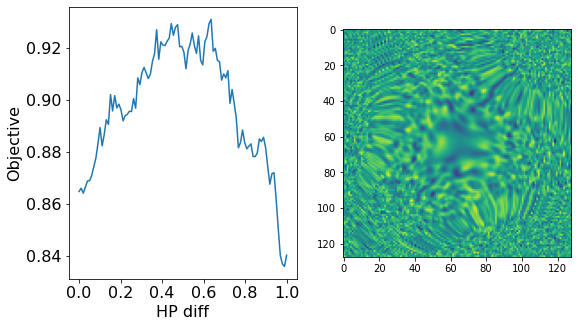

In [19]:
# Line scan for deltaH
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7

deltaH_list = np.linspace(0, 1, num=100)
emit_profile = np.zeros([100,1])
ronch_list = []
mi.setS2(1)

for i in range(len(deltaH_list)):
    
    if emit_profile[i]!=0:
        continue
    start_point = [[0.27678667, deltaH_list[i], 0.5, 0.4944, 0.71653846, 0.79012864]] 
    mi.setX(start_point)
    
    temp = mi.getState()
    defocus = mi.getDefocus()
#     if defocus < 0.85:
#         print('Correct defocus...')
#         new_S2 = mi.CorrectDefocus(mi.x, mi.S2)
#         mi.setS2(new_S2[0][0])
#         emit_profile[i] = mi.getState()[1][0]
#     else:
#         emit_profile[i] = temp[1][0]
#     defocus_list[i] = defocus
    emit_profile[i] = temp[1][0]

    clear_output(wait=True)
    print(deltaH_list[i], emit_profile[i])
    fig = plt.figure(figsize = [9,5])
    plt.subplot(121)
    plt.plot(deltaH_list, emit_profile)
    plt.xlabel('HP diff', fontsize=16)
    plt.ylabel('Objective', fontsize = 16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.locator_params(axis="x", nbins=6)
    plt.locator_params(axis="y", nbins=6)
    
    temp = np.load('ronchigram.npy')
    ronch_list.append(temp)
    plt.subplot(122)
    plt.imshow(temp)
    plt.show()
    
    np.save('deltaH_-40_40_100steps_40mrad_Coarse_CNNemittance.npy',emit_profile)
    np.save('deltaH_-40_40_100steps_RonchigramList.npy', np.asarray(ronch_list))

1.0 [0.74371272]


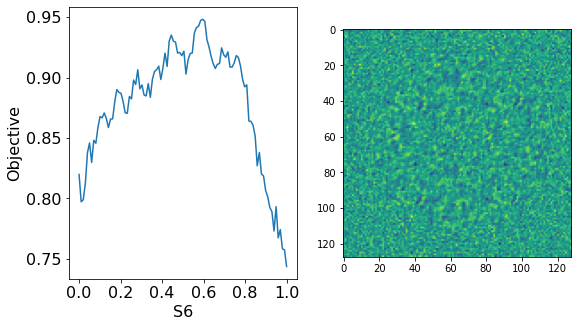

In [28]:
# Line scan for S6
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7

S6_list = np.linspace(0, 1, num=100)
emit_profile = np.zeros([100,1])
ronch_list = []
mi.setS2(1)

for i in range(len(S6_list)):

    start_point = [[0.27678667, 0.505875, S6_list[i], 0.4944, 0.71653846, 0.79012864]] 
    mi.setX(start_point)
    
    temp = mi.getState()
#     defocus = mi.getDefocus()
#     if defocus < 0.85:
#         print('Correct defocus...')
#         new_S2 = mi.CorrectDefocus(mi.x, mi.S2)
#         mi.setS2(new_S2[0][0])
#         emit_profile[i] = mi.getState()[1][0]
#     else:
#         emit_profile[i] = temp[1][0]
#     defocus_list[i] = defocus
    emit_profile[i] = temp[1][0]

    clear_output(wait=True)
    print(S6_list[i], emit_profile[i])
    
    fig = plt.figure(figsize = [9,5])
    plt.subplot(121)
    plt.plot(S6_list, emit_profile)
    plt.xlabel('S6', fontsize=16)
    plt.ylabel('Objective', fontsize = 16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.locator_params(axis="x", nbins=6)
    plt.locator_params(axis="y", nbins=6)
    
    temp = np.load('ronchigram.npy')
    ronch_list.append(temp)
    
    plt.subplot(122)
    plt.imshow(temp)
    plt.show()
    np.save('S6_3.87e5_3.93e5_100steps_40mrad_Coarse_CNNemittance.npy',emit_profile)
    np.save('S6_3.87e5_3.93e5_100steps_Ronchigram_list.npy',np.asarray(ronch_list))

1.0 [0.75953463]


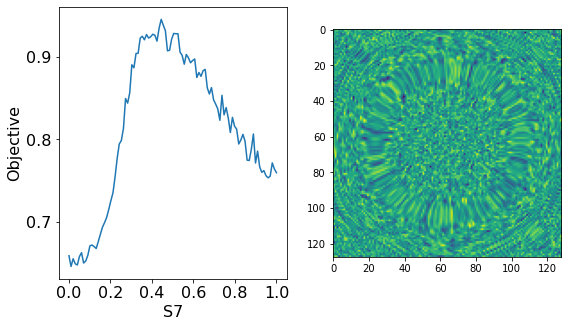

In [29]:
# Line scan for S7
# Parameters in the order of H1, H1-H2, S6, S7, OBJ, S3, S4

S7_list = np.linspace(0,1, num=100)
emit_profile = np.zeros([100,1])
defocus_list = np.zeros([100,1])
ronch_list = []
mi.setS2(1)

for i in range(len(S7_list)):
    if emit_profile[i] != 0:
        continue
    start_point = [[0.27678667, 0.505875, 0.5, S7_list[i], 0.71653846, 0.79012864]] 
    mi.setX(start_point)
    
    temp = mi.getState()
    defocus = mi.getDefocus()
#     if defocus < 0.85:
#         print('Correct defocus...')
#         new_S2 = mi.CorrectDefocus(mi.x, mi.S2)
#         mi.setS2(new_S2[0][0])
#         emit_profile[i] = mi.getState()[1][0]
#     else:
#         emit_profile[i] = temp[1][0]
#     defocus_list[i] = defocus
    emit_profile[i] = temp[1][0]

    clear_output(wait=True)
    print(S7_list[i], emit_profile[i])
    fig = plt.figure(figsize = [9,5])
    plt.subplot(121)
    plt.plot(S7_list, emit_profile)
    plt.xlabel('S7', fontsize=16)
    plt.ylabel('Objective', fontsize = 16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.locator_params(axis="x", nbins=6)
    plt.locator_params(axis="y", nbins=6)

    temp = np.load('ronchigram.npy')
    ronch_list.append(temp)
    
    plt.subplot(122)
    plt.imshow(temp)
    plt.show()
    np.save('S7_-6.85e5_-6.22e5_100steps_40mrad_Coarse_CNNemittance.npy',emit_profile)
    np.save('S7_-6.85e5_-6.22e5_100steps_Ronchigram_list.npy',np.asarray(ronch_list))

1.0 [0.69631863] [0.]


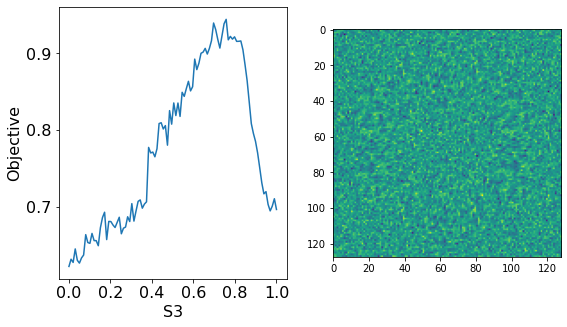

In [30]:
# Line scan for S3
# ndim = 7 #input dimension, set to 2 for two hexapoles
# acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

# dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7

S3_list = np.linspace(0, 1, num=100)
emit_profile = np.zeros([100,1])
ronch_list = []
mi.setS2(1)

for i in range(len(S3_list)):
    start_point = [[0.27678667, 0.505875, 0.5, 0.4944, S3_list[i], 0.79012864]] 
    mi.setX(start_point)
    
    temp = mi.getState()
#     defocus = mi.getDefocus()
#     if defocus < 0.85:
#         print('Correct defocus...')
#         new_S2 = mi.CorrectDefocus(mi.x, mi.S2)
#         mi.setS2(new_S2[0][0])
#         emit_profile[i] = mi.getState()[1][0]
#     else:
#         emit_profile[i] = temp[1][0]
#     defocus_list[i] = defocus
    emit_profile[i] = temp[1][0]

    clear_output(wait=True)
    print(S3_list[i], emit_profile[i], defocus_list[i])
    fig = plt.figure(figsize = [9,5])
    plt.subplot(121)
    plt.plot(S3_list, emit_profile )
    plt.xlabel('S3', fontsize=16)
    plt.ylabel('Objective', fontsize = 16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.locator_params(axis="x", nbins=6)
    plt.locator_params(axis="y", nbins=6)
    
    temp = np.load('ronchigram.npy')
    ronch_list.append(temp)
    
    plt.subplot(122)
    plt.imshow(temp)
    plt.show()
    np.save('S3_1.19e5_1.203e5_100steps_40mrad_Coarse_CNNemittance.npy',emit_profile)
    np.save('S3_1.19e5_1.203e5_100steps_Ronchigram_list.npy',np.asarray(ronch_list))

1.0 [0.68678367] [0.]


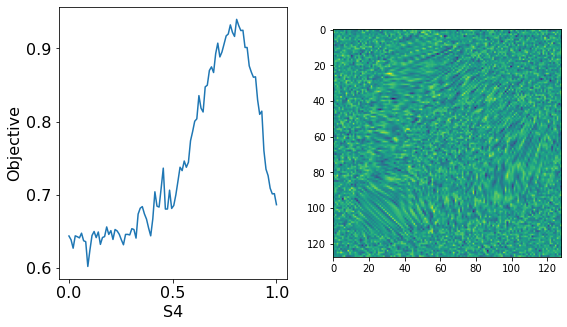

In [31]:
# Line scan for S4

S4_list = np.linspace(0, 1, num=100)
emit_profile = np.zeros([100,1])
ronch_list = []
mi.setS2(1)

for i in range(len(S4_list)):
    start_point = [[0.27678667, 0.505875, 0.5, 0.4944, 0.71653846, S4_list[i]]] 
    mi.setX(start_point)
    temp = mi.getState()
#     defocus = mi.getDefocus()
#     if defocus < 0.85:
#         print('Correct defocus...')
#         new_S2 = mi.CorrectDefocus(mi.x, mi.S2)
#         mi.setS2(new_S2[0][0])
#         emit_profile[i] = mi.getState()[1][0]
#     else:
#         emit_profile[i] = temp[1][0]
#     defocus_list[i] = defocus

    emit_profile[i] = temp[1][0]
    clear_output(wait=True)
    print(S4_list[i], emit_profile[i], defocus_list[i])

    fig = plt.figure(figsize = [9,5])
    plt.subplot(121)
    plt.plot(S4_list, emit_profile)
    plt.xlabel('S4', fontsize=16)
    plt.ylabel('Objective', fontsize = 16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.locator_params(axis="x", nbins=4)
    plt.locator_params(axis="y", nbins=6)
#     plt.axvline(x = 6.48691, c = 'r')

    temp = np.load('ronchigram.npy')
    ronch_list.append(temp)
    plt.subplot(122)
    plt.imshow(temp)
    plt.show()
    
    np.save('S4_6.4e5_6.51e5_100steps_40mrad_Coarse_CNNemittance.npy',emit_profile)
    np.save('S4_6.4e5_6.51e5_100steps_Ronchigram_list.npy',np.asarray(ronch_list))

## Combine linescans for hyperparameter trainer

In [38]:
x = []
y = []

In [39]:
# Combine the data from different linescans
H1_list = np.linspace(0, 1, num=100)
emit_profile = np.load('H1_1000_2800_100steps_40mrad_Coarse_CNNemittance.npy')
for i in range(len(H1_list)):
    start_point = [[H1_list[i], 0.505875  , 0.5       , 0.4944     , 0.71653846,
       0.79012864]] 
    x.append(start_point)
    y.append(emit_profile[i])

In [40]:
deltaH_list = np.linspace(0, 1, num=100)
emit_profile = np.load('deltaH_-40_40_100steps_40mrad_Coarse_CNNemittance.npy')

for i in range(len(deltaH_list)):
    start_point = [[0.27678667, deltaH_list[i]  , 0.5       , 0.4944     , 0.71653846,
       0.79012864]] 
    x.append(start_point)
    y.append(emit_profile[i])

In [41]:
S3_list = np.linspace(0, 1, num=100)
emit_profile = np.load('S3_1.19e5_1.203e5_100steps_40mrad_Coarse_CNNemittance.npy')

for i in range(len(S3_list)):
    start_point = [[0.27678667, 0.505875  , 0.5       , 0.4944     , S3_list[i],
       0.79012864]] 
    x.append(start_point)
    y.append(emit_profile[i])

In [42]:
S4_list = np.linspace(0, 1, num=100)
emit_profile = np.load('S4_6.4e5_6.51e5_100steps_40mrad_Coarse_CNNemittance.npy')

for i in range(len(S4_list)):
    start_point = [[0.27678667, 0.505875  , 0.5       , 0.4944     , 0.71653846, S4_list[i]]] 
    x.append(start_point)
    y.append(emit_profile[i])

In [43]:
S6_list = np.linspace(0, 1,num=100)
emit_profile = np.load('S6_3.87e5_3.93e5_100steps_40mrad_Coarse_CNNemittance.npy')

for i in range(len(S6_list)):
    start_point = [[0.27678667, 0.505875  , S6_list[i]       , 0.4944     , 0.71653846,
       0.79012864]] 
    x.append(start_point)
    y.append(emit_profile[i])

In [44]:
S7_list = np.linspace(0, 1, num=100)
emit_profile = np.load('S7_-6.85e5_-6.225e5_100steps_40mrad_Coarse_CNNemittance.npy')

for i in range(len(S7_list)):
    start_point = [[0.27678667, 0.505875  , 0.5       , S7_list[i]     , 0.71653846,
       0.79012864]] 
    x.append(start_point)
    y.append(emit_profile[i])

In [45]:
np.save('OBJ_x.npy',np.squeeze(np.asarray(x)))
np.save('OBJ_y.npy',np.squeeze(np.asarray(y)))

## Aux Functions

## Previously used scripts

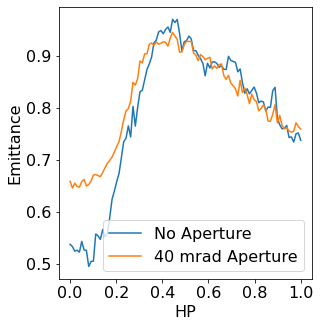

In [46]:
emit_profile_1 = np.load('Results/Linescans/VGG16_emit+defocus_test6_attempt3/S7_-6.85e5_-6.225e5_100steps_40mrad_Coarse_CNNemittance.npy')
emit_profile_2 = np.load('Results/Linescans/VGG16_emit+defocus_40mrad_test12_attempt3/S7_-6.85e5_-6.225e5_100steps_40mrad_Coarse_CNNemittance.npy')
fig = plt.figure(figsize = [10,5])
plt.subplot(121)
plt.plot(deltaH_list, emit_profile_1, label = 'No Aperture')
plt.plot(deltaH_list, emit_profile_2, label = '40 mrad Aperture')
plt.xlabel('HP', fontsize=16)
plt.ylabel('Emittance', fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.locator_params(axis="x", nbins=6)
plt.locator_params(axis="y", nbins=6)
plt.legend(fontsize = 16)
# plt.axvline(x = 0,c = 'r')

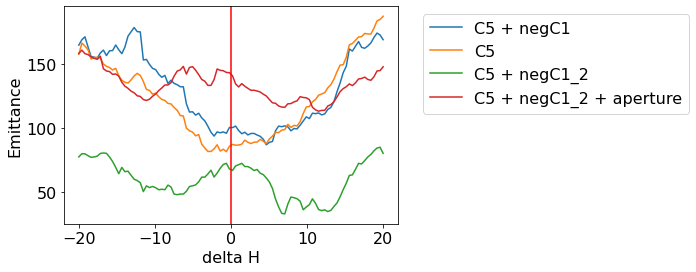

In [30]:
emit_profile = np.load('Linescans/HighCs_3fold_C5negC1_emit_WhiteNoise/deltaH_-20_20_100steps_40mrad_Coarse_CNNemittance.npy')
S6_list = np.linspace(387000,391000,num=100)
emit_profile_2 = np.load('Linescans/HighCs_3fold_C5_emit_WhiteNoise/deltaH_-20_20_100steps_40mrad_Coarse_CNNemittance.npy')
emit_profile_3 = np.load('Linescans/HighCs_3fold_C5negC1_emit_WhiteNoise_aperture/deltaH_-20_20_100steps_40mrad_Coarse_CNNemittance.npy')
plt.plot(deltaH_list, -emit_profile*1112.7, label = 'C5 + negC1')
plt.plot(deltaH_list, -emit_profile_2*1112.7, label='C5')
plt.plot(deltaH_list, -emit_profile_3 * 1112.7, label = 'C5 + negC1_2')
plt.plot(deltaH_list, prediction[:,0]*1112.7, label = 'C5 + negC1_2 + aperture')
plt.xlabel('delta H', fontsize=16)
plt.ylabel('Emittance', fontsize = 16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.locator_params(axis="x", nbins=6)
plt.locator_params(axis="y", nbins=6)
plt.axvline(x = 0, c = 'r')
plt.legend(fontsize = 16,bbox_to_anchor=(1.05, 1), loc='upper left')

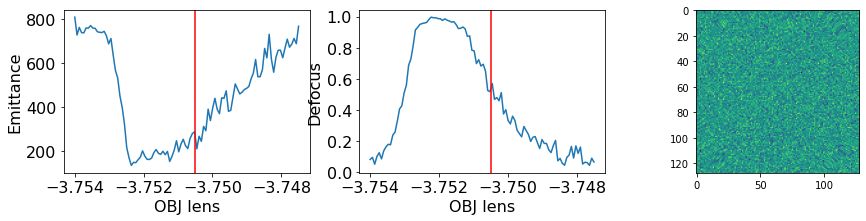

In [22]:
# Line scan for objective lens
# ndim = 7 #input dimension, set to 2 for two hexapoles
# acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

# dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7

OBJ_list = np.linspace(-3.754e6,-3.7475e6,num=100)
emit_profile = np.zeros([100,1])

y_list = np.zeros([100,1])
x_list = np.zeros([100,1])

x_low = np.asarray([ 1000, -20,  387000, -655000, -3.7515e6, 119000, 640000])
x_high = np.asarray([ 2200, 20,  391000, -635000, -3.7495e6, 120300, 651000])
ronch_list = []


for i in range(len(OBJ_list)):

#     start_point = [1498 , 0, 390000 , -654100, OBJ_list[i], 119931.5, 648691.415] # default start point
    start_point = [1798 , 10, 391000 , -654200, OBJ_list[i], 119400, 648691.415]
    start_point = [(start_point - x_low)/(x_high - x_low)]
    mi.setX(start_point)
    emit_profile[i] = mi.getState()[1][0]
    y_list[i] = mi.getDefocus()
    x_list[i] = start_point[0][4]
    clear_output(wait=True)
 
    fig = plt.figure(figsize = [15,3])
    
    plt.subplot(131)
    plt.plot(np.asarray(OBJ_list/1e6), (1-emit_profile)*1057.5)
    plt.xlabel('OBJ lens', fontsize=16)
    plt.ylabel('Emittance', fontsize = 16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.locator_params(axis="x", nbins=4)
    plt.locator_params(axis="y", nbins=6)
    plt.axvline(x = -3.7505, c = 'r')
    
    plt.subplot(132)
    plt.plot(np.asarray(OBJ_list/1e6), y_list)
    plt.xlabel('OBJ lens', fontsize=16)
    plt.ylabel('Defocus', fontsize = 16)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.locator_params(axis="x", nbins=4)
    plt.locator_params(axis="y", nbins=6)
    plt.axvline(x = -3.7505, c = 'r')
    
    temp = np.load('ronchigram.npy')
    ronch_list.append(temp)
    
    plt.subplot(133)
    plt.imshow(temp)
    plt.show()
    
np.save('OBJ_scan_03.npy', y_list)
np.save('OBJ_scan_x.npy', x_list)

-648939.3939393939
Model loaded
[-0.24690656]


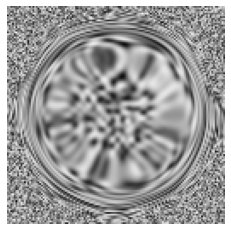

In [31]:
ndim = 7 #input dimension, set to 2 for two hexapoles
acquisition_delay = 0  #how long to wait between acquisitions- relevant for expriment, not for simulation

dev_ids =  [str(x+1) for x in np.arange(ndim)] #creat device ids (just numbers)
# Parameters in the order of H1, H1-H2, S1, S2, S3, S4, S6, S7

S7_list = np.linspace(-655000,-640000, num=100)
i = 40
print(S7_list[i])
start_point = [[1498.2, 0, 3.90e5, -647725, -3.7505e6, 119931.5, 648691.415]] 
mi_module = importlib.import_module('machine_interfaces.machine_interface_GPT')
mi = mi_module.machine_interface(dev_ids = dev_ids, start_point = start_point, CNNoption=1) #an isotropic n-dimensional gaussian with amplitude=1, centered at the origin, plus gaussian background noise with std dev = 0.1
print(mi.getState()[1][0])

temp = np.load('ronchigram.npy')
plt.imshow(temp, cmap='gray')
plt.axis('off')
plt.show()


## Load simulated Ronchigrams and calculate emittance using CNN

In [13]:
ronch_list = np.load('NoDefocusCorr_100iter_UCB_2-0_TFGP_CNNdefocus+emit_Ronchigram_01.npy')

x_list = []
for i in range(ronch_list.shape[0]):
    frame = ronch_list[i,:,:]
    frame = scale_range(frame, 0, 1)
    new_channel = np.zeros(frame.shape)
    img_stack = np.dstack((frame, new_channel, new_channel))
    x_list.append(img_stack)
x_list = np.concatenate([arr[np.newaxis] for arr in x_list])
prediction = new_model.predict(x_list, batch_size = 1)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [29]:
temp = np.load('NoDefocusCorr_100iter_UCB_2-0_TFGP_CNNdefocus+emit_01.npy')
temp = temp[:,1]
print(temp.shape)
print(np.argmax(temp))

(101,)
71


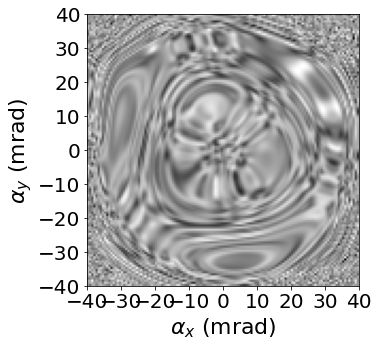

In [35]:
plt.figure(figsize=[5,5])
plt.imshow(ronch_list[99,:,:], extent=[-40,40,-40,40], cmap='gray')
plt.xlabel(r"$\alpha_x \ \mathrm{(mrad)}$",fontsize=22)
plt.ylabel(r"$\alpha_y \ \mathrm{(mrad)}$",fontsize=22)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

In [12]:
temp = prediction[:,0]
np.save('C2corr_100iter_UCB_2-0_GPy_CNNsmallDefocus_Ronchigram_01_emittance.npy', temp)

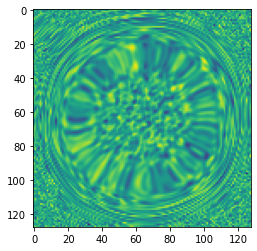

In [61]:
plt.imshow(ronch_list[59,:,:])